In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score as r2

In [4]:
#Функция для замены пропусков медианой
# def insert_median(df, column):
#     column_median = df[column].median()
#     df[column].fillna(column_median, inplace=True)

In [5]:
DATASET_TRAIN = 'train.csv'
DATASET_TEST = 'test.csv'
DATASET_SUBMIT = 'sample_submission.csv'
TEST_DATASET_EXT_PATH = 'bbmatyushin_pred.csv'

In [6]:
df = pd.read_csv(DATASET_TRAIN, sep=',')
test_df = pd.read_csv(DATASET_TEST, sep=',')

* **Уменьшаем объем памяти**

In [7]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


#### Data fields

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

In [10]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [12]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [13]:
# Заменим пропуски в колонке LifeSquare медианой
# insert_median(df, 'LifeSquare')

In [14]:
# Присвоим признакам Id и DistrictId тип str, чтобы они не учавствовали в обучении модели.
df[['Id', 'DistrictId']] = df[['Id', 'DistrictId']].astype(str)

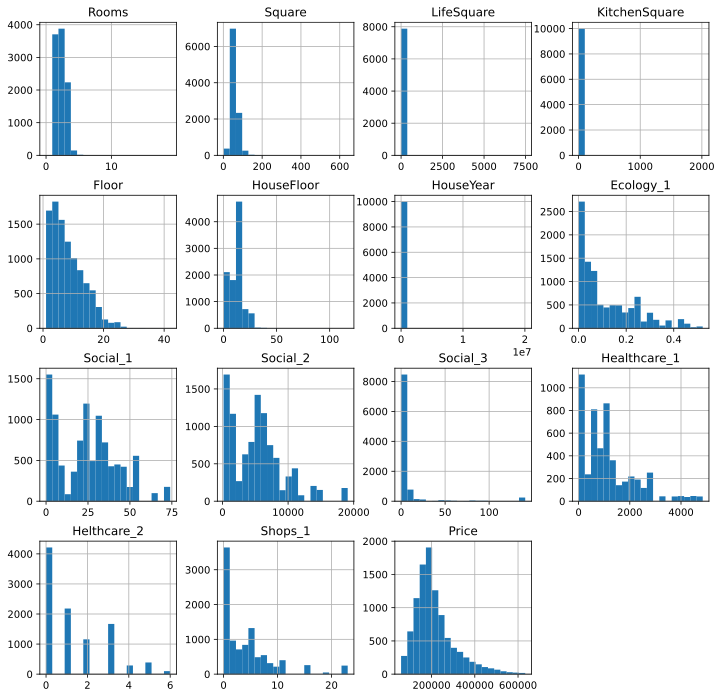

In [15]:
df = df.select_dtypes(include=('int8', 'int16', 'int32', 'int64', 'float32'))

df.hist(figsize=(12, 12), bins=20)
plt.show()

In [16]:
df.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price'],
      dtype='object')

---
* Подозрение на выбросы у признаков **LifeSquare**, **KitchenSquare**, **HouseYear**, **HouseFloor**.
* **Healthcare_1** рассмотрим отдельно.

In [17]:
df[['KitchenSquare', 'Square']].describe()

,KitchenSquare,Square
count,10000.000000,10000.000000
mean,6.273300,56.315720
std,28.560839,21.058716
min,0.000000,1.136859
25%,1.000000,41.774879
50%,6.000000,52.513309
75%,9.000000,65.900627
max,2014.000000,641.065186


<AxesSubplot:xlabel='KitchenSquare'>

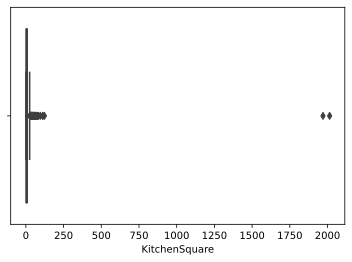

In [18]:
sns.boxplot(df['KitchenSquare'], whis=2)

In [19]:
# Высчитаем среднее значение доли кухни от общей площади и заменим выбросы этим значением.
# Добавим новый признак KitchenSquare_share.

def kitchen_share(df):
    share_mean = (df['KitchenSquare'] / df['Square']).mean()
    # Значение правого уса
    right_mustache = np.quantile(df['KitchenSquare'], 0.75) * 2 + np.quantile(df['KitchenSquare'], 0.75)
    condition = (df['KitchenSquare'] > right_mustache) |(df['KitchenSquare'] == 0)
    df.loc[condition, 'KitchenSquare'] = df.loc[condition, 'Square'] * share_mean
    df['KitchenSquare_share'] = df['KitchenSquare'] / df['Square']
    
    print(f'В среднем площадь кухни занимает {round(share_mean * 100, 2)}% от общей площади.')

In [20]:
kitchen_share(df)
df

В среднем площадь кухни занимает 12.33% от общей площади.


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,KitchenSquare_share
0,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000,0.086936
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875,0.200841
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750,0.127645
3,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000,0.024746
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750,0.140001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.453125,0.122223
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.156250,0.139952
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.906250,0.168645
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.406250,0.154654


---
* Анлогично избавимся от выбросов и с пустыми значениями в LifeSquare

In [21]:
df[['LifeSquare', 'Square']].describe()

,LifeSquare,Square
count,7887.000000,10000.000000
mean,37.199665,56.315720
std,86.241219,21.058716
min,0.370619,1.136859
25%,22.769833,41.774879
50%,32.781261,52.513309
75%,45.128803,65.900627
max,7480.592285,641.065186


<AxesSubplot:xlabel='LifeSquare'>

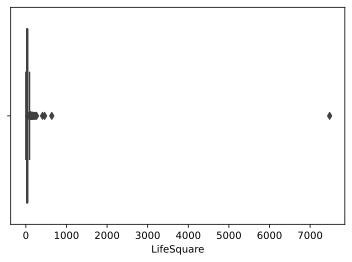

In [22]:
sns.boxplot(df['LifeSquare'], whis=2)

In [23]:
# Доля жилой площади.
# Добавляет признак, который будет показывать долю жилой площади от общей. Зная его среднее значение, можно в наблюдениях
# с жилой площадью больше чем общая уменьшить их значение до средней доли от общ.пл.

def lifesquare_share (df):
    share_mean = (df['LifeSquare'] / df['Square']).mean()
    right_mustache = np.quantile(df['LifeSquare'], 0.75) * 2 + np.quantile(df['LifeSquare'], 0.75)
    condition = (df['LifeSquare'] > df['Square']) | (df['LifeSquare'].isna())
    df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] * share_mean
    df['LifeSquare_share'] = df['LifeSquare'] / df['Square']
    
    print(f'В среднем жилая площадь занимает {round(share_mean * 100, 2)}% от общей площади.')

In [24]:
# Преобразуем такие значения в среднию долю общей жилой площади и добавим столбец с долями.
lifesquare_share(df)
df

В среднем жилая площадь занимает 66.59% от общей площади.


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,KitchenSquare_share,LifeSquare_share
0,3.0,115.027313,76.594917,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000,0.086936,0.665885
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875,0.200841,0.581666
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750,0.127645,0.608509
3,1.0,40.409908,26.908337,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000,0.024746,0.665885
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750,0.140001,0.599867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.453125,0.122223,0.677778
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.156250,0.139952,0.575956
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.906250,0.168645,0.558396
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.406250,0.154654,0.690587


<AxesSubplot:xlabel='HouseYear'>

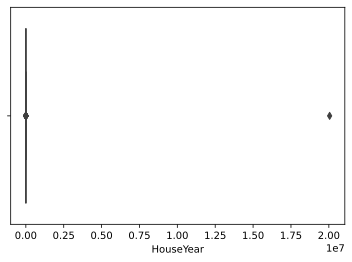

In [25]:
sns.boxplot(df['HouseYear'], whis=2)

In [26]:
df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int32

In [27]:
# Видно два выброса. Заменим их на текущий год.
from datetime import datetime

def current_year(df):
    current_year = datetime.now().year
    df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
    
current_year(df)

<AxesSubplot:xlabel='HouseFloor'>

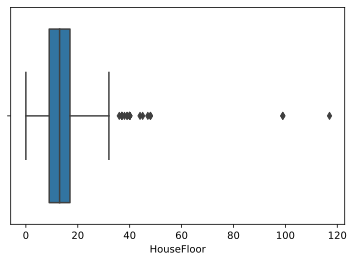

In [28]:
# Смотрим выбросы у признака HouseFloor
sns.boxplot(df['HouseFloor'], whis=2)

In [29]:
df.loc[df['HouseFloor'] > 29, 'HouseFloor'].value_counts().sort_index()

30.0     21
31.0      1
32.0      4
36.0      1
37.0      4
38.0      1
39.0      2
40.0      7
44.0      1
45.0      1
47.0      1
48.0      2
99.0      2
117.0     1
Name: HouseFloor, dtype: int64

In [30]:
# Жилые дома выше 40 этажей кажутся анамальными. Присвоим им знаение медианы.

def housefloor_median(df):
    df.loc[df['HouseFloor'] >= 40, 'HouseFloor'] = df['HouseFloor'].median()

In [31]:
housefloor_median(df)

* Рассмотрим признак **Healthcare_1**

In [32]:
df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

<AxesSubplot:>

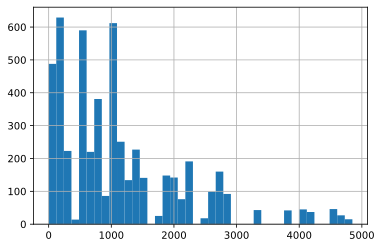

In [33]:
df['Healthcare_1'].hist(bins=40)

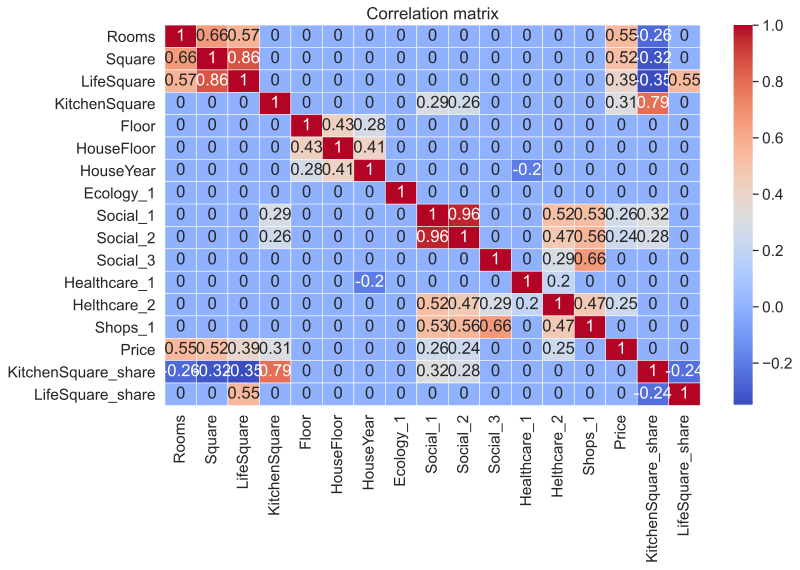

In [34]:
plt.figure(figsize = (12,7))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Healthcare_1** практически ни с кем не коррелирует, почти половина данны (4798) не заполнено.

#### Вариант 1.
* Разделить датафрейм на df1 с заполненными значенияями в Healthcare_1 и df2 - с пропусками. По df1 обучить модель предсказывать Healthcare_1 и предсказать их в df2.

#### Вариант 2.
* Удалить столбец **Healthcare_1** и так обучать модель.

---
#### ВАРИАНТ 1.

In [35]:
# Разделим датафрейм на 1) с пустыми значениями Healthcare_1 - df_hc_no 2) с заполненым Healthcare_1 df_hc_yes
df1 = df[df['Healthcare_1'].notna()]
df2 = df[df['Healthcare_1'].isna()]

In [36]:
df1.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'KitchenSquare_share', 'LifeSquare_share'],
      dtype='object')

In [37]:
feature_for_hc = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'KitchenSquare_share', 'LifeSquare_share']

col_price = ['Price'] # отдельно, т.к. для тестовых данные нужны будут признаки без Price

target_hc = ['Healthcare_1']

df1 = df1[feature_for_hc + target_hc + col_price]

X = df1[feature_for_hc]
y = df1[target_hc]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [38]:
# from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score as r2

---
* Пробовал обучить на модели **LinearRegression** - на тестовой выборке R2 = 0.167, для **RandomForestRegressor** (max_depth=20, min_samples_leaf=30, random_state=42, n_estimators=100) - R2 = 0.887. Лучший результат показала модель **GradientBoostingRegressor**.

In [39]:
gb_model_hc = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model_hc.fit(X_train, y_train)

y_train_preds = gb_model_hc.predict(X_train)
str(round(r2(y_train, y_train_preds), 3))

'1.0'

In [40]:
y_test_preds = gb_model_hc.predict(X_test)
str(round(r2(y_test, y_test_preds), 3))

'0.998'

#### Заполняем пропущенные значения Healthcare_1 с помощью обученной модели.

In [41]:
df2.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'KitchenSquare_share', 'LifeSquare_share'],
      dtype='object')

In [42]:
X2 = df2[feature_for_hc]

healthcare1 = gb_model_hc.predict(X2)

In [43]:
df2['Healthcare_1'] = healthcare1
df2['Healthcare_1']

0        732.911454
3        270.998600
4       1450.414250
8        270.998600
11       605.796493
           ...     
9993     226.373156
9995     936.639445
9996      49.316197
9997    1993.810360
9999     598.924280
Name: Healthcare_1, Length: 4798, dtype: float64

In [44]:
# Собираем ДатаФрейм обратно, объединим df1 и df2
df = pd.concat([df1, df2], ignore_index=True)

feature = df.columns.drop('Price')
target = ['Price']

X = df[feature]
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=20)

In [45]:
gb_model_price = GradientBoostingRegressor(criterion='mse',
                                     max_depth=11,
                                     min_samples_leaf=15,
                                     random_state=55,  
                                     n_estimators=100)

gb_model_price.fit(X_train, y_train)

y_train_preds = gb_model_price.predict(X_train)
str(round(r2(y_train, y_train_preds), 3))

'0.937'

In [46]:
y_valid_preds = gb_model_price.predict(X_valid)
str(round(r2(y_valid, y_valid_preds), 3))

'0.721'

In [47]:
test_df#.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698120,94.521461,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [48]:
test_df[['Id', 'DistrictId']] = test_df[['Id', 'DistrictId']].astype(str)
test_df = test_df.select_dtypes(include=('int8', 'int16', 'int32', 'int64', 'float32'))

In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float32
 1   Square         5000 non-null   float32
 2   LifeSquare     3959 non-null   float32
 3   KitchenSquare  5000 non-null   float32
 4   Floor          5000 non-null   int8   
 5   HouseFloor     5000 non-null   float32
 6   HouseYear      5000 non-null   int16  
 7   Ecology_1      5000 non-null   float32
 8   Social_1       5000 non-null   int8   
 9   Social_2       5000 non-null   int16  
 10  Social_3       5000 non-null   int16  
 11  Healthcare_1   2623 non-null   float32
 12  Helthcare_2    5000 non-null   int8   
 13  Shops_1        5000 non-null   int8   
dtypes: float32(7), int16(3), int8(4)
memory usage: 185.7 KB


In [50]:
# По такому же принципу обрабатываем пропуски и выбросы
kitchen_share(test_df)
lifesquare_share(test_df)
current_year(test_df)
housefloor_median(test_df)
test_df

В среднем площадь кухни занимает 11.5% от общей площади.
В среднем жилая площадь занимает 65.47% от общей площади.


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,KitchenSquare_share,LifeSquare_share
0,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,24,4378,0,1036.0,1,1,0.135694,0.518193
1,1.0,42.493908,27.822035,10.0,7,17.0,2017,0.072158,2,629,1,NaN,0,0,0.235328,0.654730
2,2.0,59.463676,38.932652,9.0,19,19.0,1977,0.211401,9,1892,0,NaN,0,1,0.151353,0.654730
3,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,2,475,0,NaN,0,0,0.120856,0.682710
4,1.0,53.837055,35.248734,1.0,8,17.0,1977,0.309479,35,7715,4,990.0,0,6,0.018575,0.654730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,31,6119,4,NaN,1,2,0.115801,0.702679
4996,3.0,93.698120,61.346966,10.0,21,27.0,2018,0.060753,15,2787,2,520.0,0,7,0.106726,0.654730
4997,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,28,6533,1,1015.0,2,5,0.148559,0.564620
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,33,7976,5,NaN,0,11,0.232948,0.542932


In [51]:
test_df['Healthcare_1'].describe()

count    2623.000000
mean     1146.657227
std      1044.745605
min         0.000000
25%       325.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [52]:
# Разделим датафрейм на 1) с пустыми значениями Healthcare_1 - df_hc_no 2) с заполненым Healthcare_1 df_hc_yes
test_df1 = test_df[test_df['Healthcare_1'].notna()]
test_df2 = test_df[test_df['Healthcare_1'].isna()]

# Нужно обработать признак Floor там где он больше HouseFloor !

In [53]:
test_df1 = test_df1[feature_for_hc + target_hc]

X = test_df1[feature_for_hc]
y = test_df1[target_hc]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=55)

In [54]:
gb_model_hc.fit(X_train, y_train)

y_train_preds = gb_model_hc.predict(X_train)
str(round(r2(y_train, y_train_preds), 3))

'0.999'

In [55]:
y_test_preds = gb_model_hc.predict(X_test)
str(round(r2(y_test, y_test_preds), 3))

'0.98'

---
Заполняем пропуски в Healthcare_1 у test_df2

In [56]:
test_df2.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'KitchenSquare_share',
       'LifeSquare_share'],
      dtype='object')

In [57]:
X2 = test_df2[feature_for_hc]

healthcare1 = gb_model_hc.predict(X2)
test_df2['Healthcare_1'] = healthcare1

test_df = pd.concat([test_df1, test_df2], ignore_index=True)

In [58]:
X_t = test_df[feature]

price_pred = gb_model_price.predict(X_t)

In [59]:
price_pred.mean()

215837.97804121065

In [60]:
test_df['Price'] = price_pred

In [61]:
test_df['Price'].describe()

count      5000.000000
mean     215837.978041
std       80308.859340
min       54923.658499
25%      163688.157317
50%      195847.843181
75%      246890.102638
max      569514.404111
Name: Price, dtype: float64

In [62]:
submit = pd.read_csv(DATASET_SUBMIT, sep=',')

In [63]:
submit

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
...,...,...
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0


In [64]:
submit['Price'] = test_df['Price']
submit.to_csv('bbmatyushin_pred.csv', index=False)